In [1]:
import tensorflow as tf
import tensorflow.keras.layers as layers
import torch
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


Loading the datasets

In [3]:
# project folder
deep_learning_dir = "/content/gdrive/My Drive/BMI 707 Project"

In [4]:
# get nctid's and labels
train = pd.read_csv(deep_learning_dir + "/data_formatting/training_data.tsv", sep="\t")
val = pd.read_csv(deep_learning_dir + "/data_formatting/validation_data.tsv", sep="\t")
test = pd.read_csv(deep_learning_dir + "/data_formatting/testing_data.tsv", sep="\t")

train_nctids = train["nctid"].to_numpy()
train_labels = train["label"].to_numpy()

val_nctids = val["nctid"].to_numpy()
val_labels = val["label"].to_numpy()

test_nctids = test["nctid"].to_numpy()
test_labels = test["label"].to_numpy()

Loading the embeddings

In [5]:
## diseases
with open(deep_learning_dir + "/embeddings/nctid2diseases.pkl", "rb") as handle:
  nctid2diseases = pickle.load(handle)


## eligibility criteria
with open(deep_learning_dir + "/embeddings/nctid2incl_criteria.pkl", "rb") as handle:
  nctid2incl_criteria = pickle.load(handle)

with open(deep_learning_dir + "/embeddings/nctid2excl_criteria.pkl", "rb") as handle:
  nctid2excl_criteria = pickle.load(handle)


## drugs
with open(deep_learning_dir + "/embeddings/nctid2drugs.pkl", "rb") as handle:
  nctid2drugs = pickle.load(handle)


## targets
with open(deep_learning_dir + "/embeddings/nctid2drug_targets.pkl", "rb") as handle:
  nctid2target = pickle.load(handle)

In [6]:
# convert to np array
for nctid in nctid2diseases:
  nctid2incl_criteria[nctid] = nctid2incl_criteria[nctid].numpy()
  nctid2excl_criteria[nctid] = nctid2excl_criteria[nctid].numpy()
  
  if nctid in nctid2target:
    nctid2target[nctid] = nctid2target[nctid].numpy()
  else:
    nctid2target[nctid] = np.zeros(1024, dtype=np.float32)

In [7]:
## meta data
with open(deep_learning_dir + "/embeddings/nctid2n_diseases.pkl", "rb") as handle:
  nctid2n_diseases = pickle.load(handle)


with open(deep_learning_dir + "/embeddings/length_nctid2incl_criteria.pkl", "rb") as handle:
  nctid2n_incl = pickle.load(handle)

with open(deep_learning_dir + "/embeddings/length_nctid2excl_criteria.pkl", "rb") as handle:
  nctid2n_excl = pickle.load(handle)


with open(deep_learning_dir + "/embeddings/nctid2npart_success.pkl", "rb") as handle:
  nctid2npart_success = pickle.load(handle)

In [8]:
# concatenate meta info
nctid2meta = {}

for nctid in nctid2diseases:
  nctid2meta[nctid] = np.array([nctid2n_diseases[nctid], nctid2n_incl[nctid], nctid2n_excl[nctid], 
                                nctid2npart_success[nctid][0], nctid2npart_success[nctid][1]])

Build input data for the neural network.

In [9]:
def build_data(nctids, nctid_dict):
  """
  Build NN input matrix for given list of nctid's and a dictionary,
  which maps an nctid to an embedding.
  """
  n_rows = len(nctids)
  n_cols = len(list(nctid_dict.values())[0])

  data = np.zeros((n_rows, n_cols), dtype=float)

  for i,nctid in enumerate(nctids):
    
    data[i,:] = nctid_dict[nctid]

  return data

In [10]:
# train inputs
train_data_diseases = build_data(train_nctids, nctid2diseases)
train_data_incl = build_data(train_nctids, nctid2incl_criteria)
train_data_excl = build_data(train_nctids, nctid2excl_criteria)
train_data_drug = build_data(train_nctids, nctid2drugs)
train_data_target = build_data(train_nctids, nctid2target)
train_data_meta = build_data(train_nctids, nctid2meta)

# validation inputs
val_data_diseases = build_data(val_nctids, nctid2diseases)
val_data_incl = build_data(val_nctids, nctid2incl_criteria)
val_data_excl = build_data(val_nctids, nctid2excl_criteria)
val_data_drug = build_data(val_nctids, nctid2drugs)
val_data_target = build_data(val_nctids, nctid2target)
val_data_meta = build_data(val_nctids, nctid2meta)

# test inputs
test_data_diseases = build_data(test_nctids, nctid2diseases)
test_data_incl = build_data(test_nctids, nctid2incl_criteria)
test_data_excl = build_data(test_nctids, nctid2excl_criteria)
test_data_drug = build_data(test_nctids, nctid2drugs)
test_data_target = build_data(test_nctids, nctid2target)
test_data_meta = build_data(test_nctids, nctid2meta)

In [13]:
# example
train_data_target.shape

(3094, 1024)

In [12]:
# input dims of the model, i.e. the embedding dimensions
diseases_dim = train_data_diseases.shape[1]

incl_criteria_dim = train_data_incl.shape[1]
excl_criteria_dim = train_data_excl.shape[1]

drug_dim = train_data_drug.shape[1]

targets_dim = train_data_target.shape[1]

meta_dim = train_data_meta.shape[1]

# Final Model

# Automatic model evaluation

Includes: ROC-plot, Precision-Recall curve, accuracy, ROC-AUC, PR-AUC, F1-score

In [ ]:
def mean_and_sd(l):
  return np.mean(l), np.sqrt(np.var(l))

In [ ]:
def plot_learning_curve(history, save_path=None):
  """
  Plot training and validation loss per epoch.
  """
  plt.figure(figsize=(8,5))
  plt.title("Model accuracy")

  plt.plot(history.history["loss"], label="Train", color="black")
  plt.plot(history.history["val_loss"], label="Validation", color="#990000")
  
  plt.xlabel("epoch")
  plt.ylabel("loss")
  
  plt.legend(loc="best")

  if save_path: plt.savefig(save_path)
  
  plt.show()

  



def model_performance(model, input, y_true, save_path=None):
  """
  Compute performance of 'model' applied to 'input' data with true labels 'y_true'
  Saves the ROC plot and precision-recall curve to 'save_path'

  Return: dict
    accuracy, ROC-AUC, PR-AUC, F1-score
  """

  pred_prob = model.predict(input).squeeze()
  y_pred = (pred_prob > 0.5).astype("int32")

  #fig, axes = plt.subplots(1, 2, figsize=(10, 5))

  fpr, tpr, _ = metrics.roc_curve(y_true, pred_prob)
  #metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axes[0], color="black")

  prec, recall, _ = metrics.precision_recall_curve(y_true, pred_prob)
  #metrics.PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=axes[1], color="black")

  #axes[0].set(xlabel="1 - specificity", ylabel="sensitivity", title="ROC plot")
  #axes[1].set(xlabel="recall", ylabel="precision", title="Precision-Recall Curve")

  if save_path: plt.savefig(save_path)
  
  roc_auc = metrics.auc(fpr, tpr)
  pr_auc = metrics.auc(recall, prec)

  ac = metrics.accuracy_score(y_true, y_pred)
  f1 = metrics.precision_recall_fscore_support(y_true, y_pred, average="binary")[2]

  return {"accuracy": np.round(ac, 3), "roc_auc": np.round(roc_auc, 3), 
          "pr_auc": np.round(pr_auc, 3), "F1": np.round(f1, 3)}

In [ ]:
# number of successful test trials
sum(test_labels) / len(test_labels)

0.7495636998254799

In [ ]:
min_val_loss = np.inf
best_dropout = 1.
best_lr = np.inf

In [ ]:
dropouts = np.linspace(0.2, 0.4, 6)
lrs = [0.01, 0.005, 0.001, 0.0005, 0.0001]
n_runs = 5

In [ ]:
for do in dropouts:

  for lr in lrs:
    
    print(f"Current dropout: {do}, current learning rate:{lr}")
    val_losses = np.zeros(n_runs, dtype=float)

    for i in range(n_runs):

      if i%5 == 0: print(f"Run {i} for dropout {do} and learning rate {lr}")

      # inclusion and exclusion criteria
      inclusion_input = layers.Input(shape=(incl_criteria_dim,), name="inclusion")
      inclusion_emb = layers.Dense(256, activation="relu")(inclusion_input)

      exclusion_input = layers.Input(shape=(excl_criteria_dim,), name="exclusion")
      exclusion_emb = layers.Dense(256, activation="relu")(exclusion_input)

      inclusion_exclusion_raw = layers.Concatenate()([inclusion_emb, exclusion_emb])
      ie_dropout = layers.Dropout(rate=do)(inclusion_exclusion_raw)
      inclusion_exclusion_emb = layers.Dense(256, activation="relu")(ie_dropout)

      # diseases
      diseases_input = layers.Input(shape=(diseases_dim,), name="diseases")
      diseases_emb = layers.Dense(128, activation="relu")(diseases_input)


      # drug
      drug_input = layers.Input(shape=(drug_dim,), name="drug")
      drug_emb = layers.Dense(64, activation="relu")(drug_input)

      # targets
      targets_input = layers.Input(shape=(targets_dim,), name="targets")
      targets_emb = layers.Dense(64, activation="relu")(targets_input)

      # drug-target interaction
      drug_target_raw = layers.Concatenate()([drug_emb, targets_emb])
      dt = layers.Dropout(rate=do)(drug_target_raw)
      drug_target_emb = layers.Dense(64, activation="relu")(dt)


      all_emb = layers.Concatenate()([inclusion_exclusion_emb, diseases_emb, drug_target_emb])
      ae = layers.Dropout(rate=do)(all_emb)
      trial_embedding1 = layers.Dense(128, activation="relu")(ae)

      meta_input = layers.Input(shape=(meta_dim,), name="meta")
      emb_and_meta = layers.Concatenate()([trial_embedding1, meta_input])

      trial_embedding2 = layers.Dense(64, activation="relu")(emb_and_meta)
      trial_embedding3 = layers.Dense(32, activation="relu")(trial_embedding2)

      o = layers.Dense(1, activation="sigmoid", name="trial_success")(trial_embedding3)

      model = tf.keras.Model(inputs=[inclusion_input, exclusion_input, diseases_input, drug_input, targets_input, meta_input], outputs=[o])
      # model.summary()


      # compile and train

      model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss="binary_crossentropy", metrics=["accuracy", "AUC"])
      callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

      history = model.fit(
        x={"inclusion": train_data_incl, "exclusion": train_data_excl, 
          "diseases": train_data_diseases, "drug": train_data_drug,
          "targets": train_data_target, "meta": train_data_meta},
        y={"trial_success": train_labels},
        validation_data=(
            {"inclusion": val_data_incl, "exclusion": val_data_excl,
            "diseases": val_data_diseases, "drug": val_data_drug,
            "targets": val_data_target, "meta": val_data_meta},
            {"trial_success": val_labels}
        ), 
        epochs=10,
        batch_size=128,
        callbacks=[callback]
      )

      val_losses[i] = min(history.history["val_loss"])
    
    if np.mean(val_losses) < min_val_loss:
        
        best_dropout = do
        best_lr = lr
        min_val_loss = np.mean(val_losses)
        print(f"Current best dropout: {best_dropout}, current best learning rate:{best_lr}, current best average loss: {np.mean(val_losses)}")

In [ ]:
print(best_dropout, best_lr)

# 0.32, 0.01

In [ ]:
# RUN BEST MODEL AFTER GRID SEARCH 30 TIMES
n_runs = 30

In [ ]:
val_F1 = np.zeros(n_runs, dtype=float)
val_acc = np.zeros(n_runs, dtype=float)
val_pr_auc = np.zeros(n_runs, dtype=float)
val_roc_auc = np.zeros(n_runs, dtype=float)

test_F1 = np.zeros(n_runs, dtype=float)
test_acc = np.zeros(n_runs, dtype=float)
test_pr_auc = np.zeros(n_runs, dtype=float)
test_roc_auc = np.zeros(n_runs, dtype=float)

Epoch 1/10
25/25 [==============================] - 11s 327ms/step - loss: 5.1901 - accuracy: 0.5837 - auc: 0.4969 - val_loss: 0.6553 - val_accuracy: 0.6831 - val_auc: 0.5050
Epoch 2/10
25/25 [==============================] - 7s 287ms/step - loss: 0.6480 - accuracy: 0.6658 - auc: 0.5857 - val_loss: 0.6123 - val_accuracy: 0.6802 - val_auc: 0.6481
Epoch 3/10
25/25 [==============================] - 7s 284ms/step - loss: 0.6103 - accuracy: 0.6813 - auc: 0.6581 - val_loss: 0.6064 - val_accuracy: 0.6831 - val_auc: 0.6698
Epoch 4/10
25/25 [==============================] - 5s 193ms/step - loss: 0.5893 - accuracy: 0.6894 - auc: 0.6982 - val_loss: 0.5899 - val_accuracy: 0.6744 - val_auc: 0.6827
Epoch 5/10
25/25 [==============================] - 5s 199ms/step - loss: 0.5504 - accuracy: 0.7143 - auc: 0.7569 - val_loss: 0.5811 - val_accuracy: 0.7122 - val_auc: 0.7064
Epoch 6/10
25/25 [==============================] - 5s 194ms/step - loss: 0.5093 - accuracy: 0.7524 - auc: 0.8060 - val_loss: 0.6

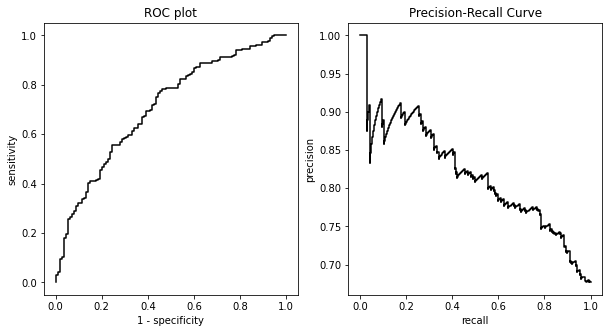

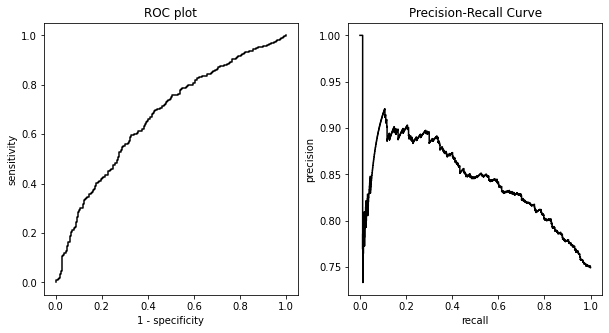

In [ ]:
for i in range(n_runs):

  # inclusion and exclusion criteria
  inclusion_input = layers.Input(shape=(incl_criteria_dim,), name="inclusion")
  inclusion_emb = layers.Dense(256, activation="relu", name="lower_dim_inclusion")(inclusion_input)

  exclusion_input = layers.Input(shape=(excl_criteria_dim,), name="exclusion")
  exclusion_emb = layers.Dense(256, activation="relu", name="lower_dim_exclusion")(exclusion_input)

  inclusion_exclusion_raw = layers.Concatenate(name="criteria")([inclusion_emb, exclusion_emb])
  ie_dropout = layers.Dropout(rate=0.32)(inclusion_exclusion_raw)
  inclusion_exclusion_emb = layers.Dense(256, activation="relu", name="lower_dim_criteria")(ie_dropout)

  # diseases
  diseases_input = layers.Input(shape=(diseases_dim,), name="diseases")
  diseases_emb = layers.Dense(128, activation="relu", name="lower_dim_diseases")(diseases_input)


  # drug
  drug_input = layers.Input(shape=(drug_dim,), name="drug")
  drug_emb = layers.Dense(64, activation="relu", name="lower_dim_drug")(drug_input)

  # targets
  targets_input = layers.Input(shape=(targets_dim,), name="targets")
  targets_emb = layers.Dense(64, activation="relu", name="lower_dim_targets")(targets_input)

  # drug-target interaction
  drug_target_raw = layers.Concatenate(name="drug-targets")([drug_emb, targets_emb])
  dt = layers.Dropout(rate=0.32)(drug_target_raw)
  drug_target_emb = layers.Dense(64, activation="relu", name="lower_dim_drug-targets")(dt)


  all_emb = layers.Concatenate(name="all_embeddings")([inclusion_exclusion_emb, diseases_emb, drug_target_emb])
  ae = layers.Dropout(rate=0.32)(all_emb)
  trial_embedding1 = layers.Dense(128, activation="relu", name="trial_embedding_1")(ae)

  meta_input = layers.Input(shape=(meta_dim,), name="meta")
  emb_and_meta = layers.Concatenate()([trial_embedding1, meta_input])

  trial_embedding2 = layers.Dense(64, activation="relu", name="trial_embedding_2")(emb_and_meta)
  trial_embedding3 = layers.Dense(32, activation="relu", name="trial_embedding_3")(trial_embedding2)

  o = layers.Dense(1, activation="sigmoid", name="trial_success")(trial_embedding3)

  model = tf.keras.Model(inputs=[inclusion_input, exclusion_input, diseases_input, drug_input, targets_input, meta_input], outputs=[o])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy", "AUC"])
  callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

  history = model.fit(
    x={"inclusion": train_data_incl, "exclusion": train_data_excl, 
      "diseases": train_data_diseases, "drug": train_data_drug,
      "targets": train_data_target, "meta": train_data_meta},
    y={"trial_success": train_labels},
    validation_data=(
        {"inclusion": val_data_incl, "exclusion": val_data_excl,
        "diseases": val_data_diseases, "drug": val_data_drug,
        "targets": val_data_target, "meta": val_data_meta},
        {"trial_success": val_labels}
    ), 
    epochs=10,
    batch_size=128,
    callbacks=[callback]
  )


  val_metrics = model_performance(
    model,
    {"inclusion": val_data_incl, "exclusion": val_data_excl, 
    "diseases": val_data_diseases, "drug": val_data_drug,
    "targets": val_data_target, "meta": val_data_meta},
    val_labels,
    save_path=None
  )

  test_metrics = model_performance(
    model,
    {"inclusion": test_data_incl, "exclusion": test_data_excl, 
    "diseases": test_data_diseases, "drug": test_data_drug,
    "targets": test_data_target, "meta": test_data_meta},
    test_labels,
    save_path=None
  )

  val_F1[i] = val_metrics["F1"]
  val_acc[i] = val_metrics["accuracy"]
  val_pr_auc[i] = val_metrics["pr_auc"]
  val_roc_auc[i] = val_metrics["roc_auc"]

  test_F1[i] = test_metrics["F1"]
  test_acc[i] = test_metrics["accuracy"]
  test_pr_auc[i] = test_metrics["pr_auc"]
  test_roc_auc[i] = test_metrics["roc_auc"]

In [ ]:
val_F1_mean, val_F1_sd = mean_and_sd(val_F1)
val_acc_mean, val_acc_sd = mean_and_sd(val_acc)
val_pr_auc_mean, val_pr_auc_sd = mean_and_sd(val_pr_auc)
val_roc_auc_mean, val_roc_auc_sd = mean_and_sd(val_roc_auc)

test_F1_mean, test_F1_sd = mean_and_sd(test_F1)
test_acc_mean, test_acc_sd = mean_and_sd(test_acc)
test_pr_auc_mean, test_pr_auc_sd = mean_and_sd(test_pr_auc)
test_roc_auc_mean, test_roc_auc_sd = mean_and_sd(test_roc_auc)

In [ ]:
print(f"validation F1: {round(val_F1_mean, 3)} +/- {round(val_F1_sd, 3)}")
print(f"test F1: {round(test_F1_mean, 3)} +/- {round(test_F1_sd, 3)}")

print(f"validation accuracy: {round(val_acc_mean, 3)} +/- {round(val_acc_sd, 3)}")
print(f"test accuracy: {round(test_acc_mean, 3)} +/- {round(test_acc_sd, 3)}")

print(f"validation PR-AUC: {round(val_pr_auc_mean, 3)} +/- {round(val_pr_auc_sd, 3)}")
print(f"test PR-AUC: {round(test_pr_auc_mean, 3)} +/- {round(test_pr_auc_sd, 3)}")

print(f"validation ROC-AUC: {round(val_roc_auc_mean, 3)} +/- {round(val_roc_auc_sd, 3)}")
print(f"test ROC-AUC: {round(test_roc_auc_mean, 3)} +/- {round(test_roc_auc_sd, 3)}")

validation F1: 0.787 +/- 0.016
test F1: 0.831 +/- 0.027
validation accuracy: 0.679 +/- 0.012
test accuracy: 0.728 +/- 0.028
validation PR-AUC: 0.799 +/- 0.013
test PR-AUC: 0.841 +/- 0.009
validation ROC-AUC: 0.665 +/- 0.026
test ROC-AUC: 0.65 +/- 0.032


In [ ]:
model.save(deep_learning_dir + "/MLP_models/model_weights_plot")

# model = tf.keras.models.load_model(deep_learning_dir + "clinical_trial_model_weights")

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/BMI 707 Project/MLP_models/model_weights_plot/assets


Model structure

In [ ]:
# print model structure
tf.keras.utils.plot_model(model, "clinical_trial_model.pdf", show_shapes=True)

In [ ]:
!mv clinical_trial_model.pdf "/content/gdrive/My Drive/BMI 707 Project/MLP_models/"

In [ ]:
plot_learning_curve(history, save_path="/content/gdrive/My Drive/BMI 707 Project/MLP_models/loss_history.pdf")

In [ ]:
model_metrics = model_performance(
  model,
  {"inclusion": test_data_incl, "exclusion": test_data_excl, 
   "diseases": test_data_diseases, "drug": test_data_drug,
   "targets": test_data_target, "meta": test_data_meta},
  test_labels,
  save_path=deep_learning_dir+"/MLP_models/model_performance.pdf"
)

In [ ]:
model_metrics

{'F1': 0.83, 'accuracy': 0.727, 'pr_auc': 0.844, 'roc_auc': 0.67}

# Leave one out models

### Without eligibility criteria

In [ ]:
n_runs = 30

In [ ]:
val_F1 = np.zeros(n_runs, dtype=float)
val_acc = np.zeros(n_runs, dtype=float)
val_pr_auc = np.zeros(n_runs, dtype=float)
val_roc_auc = np.zeros(n_runs, dtype=float)

test_F1 = np.zeros(n_runs, dtype=float)
test_acc = np.zeros(n_runs, dtype=float)
test_pr_auc = np.zeros(n_runs, dtype=float)
test_roc_auc = np.zeros(n_runs, dtype=float)

In [ ]:
for i in range(n_runs):

  # diseases
  diseases_input = layers.Input(shape=(diseases_dim,), name="diseases")
  diseases_emb = layers.Dense(128, activation="relu", name="lower_dim_diseases")(diseases_input)


  # drug
  drug_input = layers.Input(shape=(drug_dim,), name="drug")
  drug_emb = layers.Dense(64, activation="relu", name="lower_dim_drug")(drug_input)

  # targets
  targets_input = layers.Input(shape=(targets_dim,), name="targets")
  targets_emb = layers.Dense(64, activation="relu", name="lower_dim_targets")(targets_input)

  # drug-target interaction
  drug_target_raw = layers.Concatenate(name="drug-targets")([drug_emb, targets_emb])
  dt = layers.Dropout(rate=0.32)(drug_target_raw)
  drug_target_emb = layers.Dense(64, activation="relu", name="lower_dim_drug-targets")(dt)


  all_emb = layers.Concatenate(name="all_embeddings")([diseases_emb, drug_target_emb])
  ae = layers.Dropout(rate=0.32)(all_emb)
  trial_embedding1 = layers.Dense(128, activation="relu", name="trial_embedding_1")(ae)

  meta_input = layers.Input(shape=(meta_dim,), name="meta")
  emb_and_meta = layers.Concatenate()([trial_embedding1, meta_input])

  trial_embedding2 = layers.Dense(64, activation="relu", name="trial_embedding_2")(emb_and_meta)
  trial_embedding3 = layers.Dense(32, activation="relu", name="trial_embedding_3")(trial_embedding2)

  o = layers.Dense(1, activation="sigmoid", name="trial_success")(trial_embedding3)

  model = tf.keras.Model(inputs=[diseases_input, drug_input, targets_input, meta_input], outputs=[o])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy", "AUC"])

  history = model.fit(
    x={"diseases": train_data_diseases, "drug": train_data_drug,
      "targets": train_data_target, "meta": train_data_meta},
    y={"trial_success": train_labels},
    validation_data=(
        {"diseases": val_data_diseases, "drug": val_data_drug,
        "targets": val_data_target, "meta": val_data_meta},
        {"trial_success": val_labels}
    ), 
    epochs=5,
    batch_size=128
  )


  val_metrics = model_performance(
    model,
    {"diseases": val_data_diseases, "drug": val_data_drug,
    "targets": val_data_target, "meta": val_data_meta},
    val_labels,
    save_path=None
  )

  test_metrics = model_performance(
    model,
    {"diseases": test_data_diseases, "drug": test_data_drug,
    "targets": test_data_target, "meta": test_data_meta},
    test_labels,
    save_path=None
  )

  val_F1[i] = val_metrics["F1"]
  val_acc[i] = val_metrics["accuracy"]
  val_pr_auc[i] = val_metrics["pr_auc"]
  val_roc_auc[i] = val_metrics["roc_auc"]

  test_F1[i] = test_metrics["F1"]
  test_acc[i] = test_metrics["accuracy"]
  test_pr_auc[i] = test_metrics["pr_auc"]
  test_roc_auc[i] = test_metrics["roc_auc"]

In [ ]:
val_F1_mean, val_F1_sd = mean_and_sd(val_F1)
val_acc_mean, val_acc_sd = mean_and_sd(val_acc)
val_pr_auc_mean, val_pr_auc_sd = mean_and_sd(val_pr_auc)
val_roc_auc_mean, val_roc_auc_sd = mean_and_sd(val_roc_auc)

test_F1_mean, test_F1_sd = mean_and_sd(test_F1)
test_acc_mean, test_acc_sd = mean_and_sd(test_acc)
test_pr_auc_mean, test_pr_auc_sd = mean_and_sd(test_pr_auc)
test_roc_auc_mean, test_roc_auc_sd = mean_and_sd(test_roc_auc)

In [ ]:
print(f"validation F1: {round(val_F1_mean, 3)} +/- {round(val_F1_sd, 3)}")
print(f"test F1: {round(test_F1_mean, 3)} +/- {round(test_F1_sd, 3)}")

print(f"validation accuracy: {round(val_acc_mean, 3)} +/- {round(val_acc_sd, 3)}")
print(f"test accuracy: {round(test_acc_mean, 3)} +/- {round(test_acc_sd, 3)}")

print(f"validation PR-AUC: {round(val_pr_auc_mean, 3)} +/- {round(val_pr_auc_sd, 3)}")
print(f"test PR-AUC: {round(test_pr_auc_mean, 3)} +/- {round(test_pr_auc_sd, 3)}")

print(f"validation ROC-AUC: {round(val_roc_auc_mean, 3)} +/- {round(val_roc_auc_sd, 3)}")
print(f"test ROC-AUC: {round(test_roc_auc_mean, 3)} +/- {round(test_roc_auc_sd, 3)}")

validation F1: 0.781 +/- 0.012
test F1: 0.817 +/- 0.02
validation accuracy: 0.667 +/- 0.012
test accuracy: 0.71 +/- 0.021
validation PR-AUC: 0.795 +/- 0.013
test PR-AUC: 0.83 +/- 0.011
validation ROC-AUC: 0.659 +/- 0.02
test ROC-AUC: 0.631 +/- 0.022


### Without target data

In [ ]:
n_runs = 30

In [ ]:
val_F1 = np.zeros(n_runs, dtype=float)
val_acc = np.zeros(n_runs, dtype=float)
val_pr_auc = np.zeros(n_runs, dtype=float)
val_roc_auc = np.zeros(n_runs, dtype=float)

test_F1 = np.zeros(n_runs, dtype=float)
test_acc = np.zeros(n_runs, dtype=float)
test_pr_auc = np.zeros(n_runs, dtype=float)
test_roc_auc = np.zeros(n_runs, dtype=float)

In [ ]:
for i in range(n_runs):

  # inclusion and exclusion criteria
  inclusion_input = layers.Input(shape=(incl_criteria_dim,), name="inclusion")
  inclusion_emb = layers.Dense(256, activation="relu", name="lower_dim_inclusion")(inclusion_input)

  exclusion_input = layers.Input(shape=(excl_criteria_dim,), name="exclusion")
  exclusion_emb = layers.Dense(256, activation="relu", name="lower_dim_exclusion")(exclusion_input)

  inclusion_exclusion_raw = layers.Concatenate(name="criteria")([inclusion_emb, exclusion_emb])
  ie_dropout = layers.Dropout(rate=0.32)(inclusion_exclusion_raw)
  inclusion_exclusion_emb = layers.Dense(256, activation="relu", name="lower_dim_criteria")(ie_dropout)

  # diseases
  diseases_input = layers.Input(shape=(diseases_dim,), name="diseases")
  diseases_emb = layers.Dense(128, activation="relu", name="lower_dim_diseases")(diseases_input)


  # drug
  drug_input = layers.Input(shape=(drug_dim,), name="drug")
  drug_emb = layers.Dense(64, activation="relu", name="lower_dim_drug")(drug_input)


  all_emb = layers.Concatenate(name="all_embeddings")([inclusion_exclusion_emb, diseases_emb, drug_emb])
  ae = layers.Dropout(rate=0.32)(all_emb)
  trial_embedding1 = layers.Dense(128, activation="relu", name="trial_embedding_1")(ae)

  meta_input = layers.Input(shape=(meta_dim,), name="meta")
  emb_and_meta = layers.Concatenate()([trial_embedding1, meta_input])

  trial_embedding2 = layers.Dense(64, activation="relu", name="trial_embedding_2")(emb_and_meta)
  trial_embedding3 = layers.Dense(32, activation="relu", name="trial_embedding_3")(trial_embedding2)

  o = layers.Dense(1, activation="sigmoid", name="trial_success")(trial_embedding3)

  model = tf.keras.Model(inputs=[inclusion_input, exclusion_input, diseases_input, drug_input, meta_input], outputs=[o])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy", "AUC"])

  history = model.fit(
    x={"inclusion": train_data_incl, "exclusion": train_data_excl, 
      "diseases": train_data_diseases, "drug": train_data_drug,
      "meta": train_data_meta},
    y={"trial_success": train_labels},
    validation_data=(
        {"inclusion": val_data_incl, "exclusion": val_data_excl,
        "diseases": val_data_diseases, "drug": val_data_drug,
        "meta": val_data_meta},
        {"trial_success": val_labels}
    ), 
    epochs=5,
    batch_size=128
  )


  val_metrics = model_performance(
    model,
    {"inclusion": val_data_incl, "exclusion": val_data_excl, 
    "diseases": val_data_diseases, "drug": val_data_drug,
    "meta": val_data_meta},
    val_labels,
    save_path=None
  )

  test_metrics = model_performance(
    model,
    {"inclusion": test_data_incl, "exclusion": test_data_excl, 
    "diseases": test_data_diseases, "drug": test_data_drug, 
    "meta": test_data_meta},
    test_labels,
    save_path=None
  )

  val_F1[i] = val_metrics["F1"]
  val_acc[i] = val_metrics["accuracy"]
  val_pr_auc[i] = val_metrics["pr_auc"]
  val_roc_auc[i] = val_metrics["roc_auc"]

  test_F1[i] = test_metrics["F1"]
  test_acc[i] = test_metrics["accuracy"]
  test_pr_auc[i] = test_metrics["pr_auc"]
  test_roc_auc[i] = test_metrics["roc_auc"]

Epoch 1/5
25/25 [==============================] - 7s 210ms/step - loss: 3.0516 - accuracy: 0.5915 - auc: 0.5278 - val_loss: 0.7818 - val_accuracy: 0.6628 - val_auc: 0.5612
Epoch 2/5
25/25 [==============================] - 5s 195ms/step - loss: 0.7825 - accuracy: 0.6574 - auc: 0.6027 - val_loss: 0.6396 - val_accuracy: 0.6744 - val_auc: 0.6260
Epoch 3/5
25/25 [==============================] - 5s 192ms/step - loss: 0.7362 - accuracy: 0.6642 - auc: 0.6320 - val_loss: 0.6168 - val_accuracy: 0.6773 - val_auc: 0.6550
Epoch 4/5
25/25 [==============================] - 5s 197ms/step - loss: 0.6388 - accuracy: 0.6800 - auc: 0.6745 - val_loss: 0.6311 - val_accuracy: 0.6773 - val_auc: 0.6396
Epoch 5/5
25/25 [==============================] - 5s 200ms/step - loss: 0.6032 - accuracy: 0.6949 - auc: 0.7047 - val_loss: 0.6036 - val_accuracy: 0.6890 - val_auc: 0.6658
Epoch 1/5
25/25 [==============================] - 8s 223ms/step - loss: 3.2503 - accuracy: 0.5695 - auc: 0.5043 - val_loss: 0.6779 - v

In [ ]:
val_F1_mean, val_F1_sd = mean_and_sd(val_F1)
val_acc_mean, val_acc_sd = mean_and_sd(val_acc)
val_pr_auc_mean, val_pr_auc_sd = mean_and_sd(val_pr_auc)
val_roc_auc_mean, val_roc_auc_sd = mean_and_sd(val_roc_auc)

test_F1_mean, test_F1_sd = mean_and_sd(test_F1)
test_acc_mean, test_acc_sd = mean_and_sd(test_acc)
test_pr_auc_mean, test_pr_auc_sd = mean_and_sd(test_pr_auc)
test_roc_auc_mean, test_roc_auc_sd = mean_and_sd(test_roc_auc)

In [ ]:
print(f"validation F1: {round(val_F1_mean, 3)} +/- {round(val_F1_sd, 3)}")
print(f"test F1: {round(test_F1_mean, 3)} +/- {round(test_F1_sd, 3)}")

print(f"validation accuracy: {round(val_acc_mean, 3)} +/- {round(val_acc_sd, 3)}")
print(f"test accuracy: {round(test_acc_mean, 3)} +/- {round(test_acc_sd, 3)}")

print(f"validation PR-AUC: {round(val_pr_auc_mean, 3)} +/- {round(val_pr_auc_sd, 3)}")
print(f"test PR-AUC: {round(test_pr_auc_mean, 3)} +/- {round(test_pr_auc_sd, 3)}")

print(f"validation ROC-AUC: {round(val_roc_auc_mean, 3)} +/- {round(val_roc_auc_sd, 3)}")
print(f"test ROC-AUC: {round(test_roc_auc_mean, 3)} +/- {round(test_roc_auc_sd, 3)}")

validation F1: 0.784 +/- 0.02
test F1: 0.822 +/- 0.042
validation accuracy: 0.677 +/- 0.014
test accuracy: 0.719 +/- 0.04
validation PR-AUC: 0.798 +/- 0.018
test PR-AUC: 0.839 +/- 0.008
validation ROC-AUC: 0.674 +/- 0.017
test ROC-AUC: 0.649 +/- 0.015


### Without disease data

In [ ]:
n_runs = 30

In [ ]:
val_F1 = np.zeros(n_runs, dtype=float)
val_acc = np.zeros(n_runs, dtype=float)
val_pr_auc = np.zeros(n_runs, dtype=float)
val_roc_auc = np.zeros(n_runs, dtype=float)

test_F1 = np.zeros(n_runs, dtype=float)
test_acc = np.zeros(n_runs, dtype=float)
test_pr_auc = np.zeros(n_runs, dtype=float)
test_roc_auc = np.zeros(n_runs, dtype=float)

In [ ]:
for i in range(n_runs):

  # inclusion and exclusion criteria
  inclusion_input = layers.Input(shape=(incl_criteria_dim,), name="inclusion")
  inclusion_emb = layers.Dense(256, activation="relu", name="lower_dim_inclusion")(inclusion_input)

  exclusion_input = layers.Input(shape=(excl_criteria_dim,), name="exclusion")
  exclusion_emb = layers.Dense(256, activation="relu", name="lower_dim_exclusion")(exclusion_input)

  inclusion_exclusion_raw = layers.Concatenate(name="criteria")([inclusion_emb, exclusion_emb])
  ie_dropout = layers.Dropout(rate=0.32)(inclusion_exclusion_raw)
  inclusion_exclusion_emb = layers.Dense(256, activation="relu", name="lower_dim_criteria")(ie_dropout)


  # drug
  drug_input = layers.Input(shape=(drug_dim,), name="drug")
  drug_emb = layers.Dense(64, activation="relu", name="lower_dim_drug")(drug_input)

  # targets
  targets_input = layers.Input(shape=(targets_dim,), name="targets")
  targets_emb = layers.Dense(64, activation="relu", name="lower_dim_targets")(targets_input)

  # drug-target interaction
  drug_target_raw = layers.Concatenate(name="drug-targets")([drug_emb, targets_emb])
  dt = layers.Dropout(rate=0.32)(drug_target_raw)
  drug_target_emb = layers.Dense(64, activation="relu", name="lower_dim_drug-targets")(dt)


  all_emb = layers.Concatenate(name="all_embeddings")([inclusion_exclusion_emb, drug_target_emb])
  ae = layers.Dropout(rate=0.32)(all_emb)
  trial_embedding1 = layers.Dense(128, activation="relu", name="trial_embedding_1")(ae)

  meta_input = layers.Input(shape=(meta_dim,), name="meta")
  emb_and_meta = layers.Concatenate()([trial_embedding1, meta_input])

  trial_embedding2 = layers.Dense(64, activation="relu", name="trial_embedding_2")(emb_and_meta)
  trial_embedding3 = layers.Dense(32, activation="relu", name="trial_embedding_3")(trial_embedding2)

  o = layers.Dense(1, activation="sigmoid", name="trial_success")(trial_embedding3)

  model = tf.keras.Model(inputs=[inclusion_input, exclusion_input, drug_input, targets_input, meta_input], outputs=[o])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy", "AUC"])

  history = model.fit(
    x={"inclusion": train_data_incl, "exclusion": train_data_excl, 
      "drug": train_data_drug, "targets": train_data_target,
      "meta": train_data_meta},
    y={"trial_success": train_labels},
    validation_data=(
        {"inclusion": val_data_incl, "exclusion": val_data_excl,
        "drug": val_data_drug, "targets": val_data_target,
        "meta": val_data_meta},
        {"trial_success": val_labels}
    ), 
    epochs=5,
    batch_size=128
  )


  val_metrics = model_performance(
    model,
    {"inclusion": val_data_incl, "exclusion": val_data_excl, 
    "drug": val_data_drug, "targets": val_data_target,
    "meta": val_data_meta},
    val_labels,
    save_path=None
  )

  test_metrics = model_performance(
    model,
    {"inclusion": test_data_incl, "exclusion": test_data_excl, 
    "drug": test_data_drug, "targets": test_data_target,
    "meta": test_data_meta},
    test_labels,
    save_path=None
  )

  val_F1[i] = val_metrics["F1"]
  val_acc[i] = val_metrics["accuracy"]
  val_pr_auc[i] = val_metrics["pr_auc"]
  val_roc_auc[i] = val_metrics["roc_auc"]

  test_F1[i] = test_metrics["F1"]
  test_acc[i] = test_metrics["accuracy"]
  test_pr_auc[i] = test_metrics["pr_auc"]
  test_roc_auc[i] = test_metrics["roc_auc"]

In [ ]:
val_F1_mean, val_F1_sd = mean_and_sd(val_F1)
val_acc_mean, val_acc_sd = mean_and_sd(val_acc)
val_pr_auc_mean, val_pr_auc_sd = mean_and_sd(val_pr_auc)
val_roc_auc_mean, val_roc_auc_sd = mean_and_sd(val_roc_auc)

test_F1_mean, test_F1_sd = mean_and_sd(test_F1)
test_acc_mean, test_acc_sd = mean_and_sd(test_acc)
test_pr_auc_mean, test_pr_auc_sd = mean_and_sd(test_pr_auc)
test_roc_auc_mean, test_roc_auc_sd = mean_and_sd(test_roc_auc)

In [ ]:
print(f"validation F1: {round(val_F1_mean, 3)} +/- {round(val_F1_sd, 3)}")
print(f"test F1: {round(test_F1_mean, 3)} +/- {round(test_F1_sd, 3)}")

print(f"validation accuracy: {round(val_acc_mean, 3)} +/- {round(val_acc_sd, 3)}")
print(f"test accuracy: {round(test_acc_mean, 3)} +/- {round(test_acc_sd, 3)}")

print(f"validation PR-AUC: {round(val_pr_auc_mean, 3)} +/- {round(val_pr_auc_sd, 3)}")
print(f"test PR-AUC: {round(test_pr_auc_mean, 3)} +/- {round(test_pr_auc_sd, 3)}")

print(f"validation ROC-AUC: {round(val_roc_auc_mean, 3)} +/- {round(val_roc_auc_sd, 3)}")
print(f"test ROC-AUC: {round(test_roc_auc_mean, 3)} +/- {round(test_roc_auc_sd, 3)}")

validation F1: 0.798 +/- 0.007
test F1: 0.838 +/- 0.019
validation accuracy: 0.685 +/- 0.011
test accuracy: 0.729 +/- 0.023
validation PR-AUC: 0.754 +/- 0.012
test PR-AUC: 0.814 +/- 0.012
validation ROC-AUC: 0.639 +/- 0.013
test ROC-AUC: 0.604 +/- 0.024


### Without drug data

In [ ]:
n_runs = 30

In [ ]:
val_F1 = np.zeros(n_runs, dtype=float)
val_acc = np.zeros(n_runs, dtype=float)
val_pr_auc = np.zeros(n_runs, dtype=float)
val_roc_auc = np.zeros(n_runs, dtype=float)

test_F1 = np.zeros(n_runs, dtype=float)
test_acc = np.zeros(n_runs, dtype=float)
test_pr_auc = np.zeros(n_runs, dtype=float)
test_roc_auc = np.zeros(n_runs, dtype=float)

In [ ]:
for i in range(n_runs):

  # inclusion and exclusion criteria
  inclusion_input = layers.Input(shape=(incl_criteria_dim,), name="inclusion")
  inclusion_emb = layers.Dense(256, activation="relu", name="lower_dim_inclusion")(inclusion_input)

  exclusion_input = layers.Input(shape=(excl_criteria_dim,), name="exclusion")
  exclusion_emb = layers.Dense(256, activation="relu", name="lower_dim_exclusion")(exclusion_input)

  inclusion_exclusion_raw = layers.Concatenate(name="criteria")([inclusion_emb, exclusion_emb])
  ie_dropout = layers.Dropout(rate=0.32)(inclusion_exclusion_raw)
  inclusion_exclusion_emb = layers.Dense(256, activation="relu", name="lower_dim_criteria")(ie_dropout)

  # diseases
  diseases_input = layers.Input(shape=(diseases_dim,), name="diseases")
  diseases_emb = layers.Dense(128, activation="relu", name="lower_dim_diseases")(diseases_input)

  # targets
  targets_input = layers.Input(shape=(targets_dim,), name="targets")
  targets_emb = layers.Dense(64, activation="relu", name="lower_dim_targets")(targets_input)


  all_emb = layers.Concatenate(name="all_embeddings")([inclusion_exclusion_emb, diseases_emb, targets_emb])
  ae = layers.Dropout(rate=0.32)(all_emb)
  trial_embedding1 = layers.Dense(128, activation="relu", name="trial_embedding_1")(ae)

  meta_input = layers.Input(shape=(meta_dim,), name="meta")
  emb_and_meta = layers.Concatenate()([trial_embedding1, meta_input])

  trial_embedding2 = layers.Dense(64, activation="relu", name="trial_embedding_2")(emb_and_meta)
  trial_embedding3 = layers.Dense(32, activation="relu", name="trial_embedding_3")(trial_embedding2)

  o = layers.Dense(1, activation="sigmoid", name="trial_success")(trial_embedding3)

  model = tf.keras.Model(inputs=[inclusion_input, exclusion_input, diseases_input, targets_input, meta_input], outputs=[o])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy", "AUC"])

  history = model.fit(
    x={"inclusion": train_data_incl, "exclusion": train_data_excl,
       "diseases": train_data_diseases, "targets": train_data_target,
      "meta": train_data_meta},
    y={"trial_success": train_labels},
    validation_data=(
        {"inclusion": val_data_incl, "exclusion": val_data_excl,
        "diseases": val_data_diseases, "targets": val_data_target,
        "meta": val_data_meta},
        {"trial_success": val_labels}
    ), 
    epochs=5,
    batch_size=128
  )


  val_metrics = model_performance(
    model,
    {"inclusion": val_data_incl, "exclusion": val_data_excl, 
    "diseases": val_data_diseases, "targets": val_data_target,
    "meta": val_data_meta},
    val_labels,
    save_path=None
  )

  test_metrics = model_performance(
    model,
    {"inclusion": test_data_incl, "exclusion": test_data_excl, 
    "diseases": test_data_diseases, "targets": test_data_target,
    "meta": test_data_meta},
    test_labels,
    save_path=None
  )

  val_F1[i] = val_metrics["F1"]
  val_acc[i] = val_metrics["accuracy"]
  val_pr_auc[i] = val_metrics["pr_auc"]
  val_roc_auc[i] = val_metrics["roc_auc"]

  test_F1[i] = test_metrics["F1"]
  test_acc[i] = test_metrics["accuracy"]
  test_pr_auc[i] = test_metrics["pr_auc"]
  test_roc_auc[i] = test_metrics["roc_auc"]

In [ ]:
val_F1_mean, val_F1_sd = mean_and_sd(val_F1)
val_acc_mean, val_acc_sd = mean_and_sd(val_acc)
val_pr_auc_mean, val_pr_auc_sd = mean_and_sd(val_pr_auc)
val_roc_auc_mean, val_roc_auc_sd = mean_and_sd(val_roc_auc)

test_F1_mean, test_F1_sd = mean_and_sd(test_F1)
test_acc_mean, test_acc_sd = mean_and_sd(test_acc)
test_pr_auc_mean, test_pr_auc_sd = mean_and_sd(test_pr_auc)
test_roc_auc_mean, test_roc_auc_sd = mean_and_sd(test_roc_auc)

In [ ]:
print(f"validation F1: {round(val_F1_mean, 3)} +/- {round(val_F1_sd, 3)}")
print(f"test F1: {round(test_F1_mean, 3)} +/- {round(test_F1_sd, 3)}")

print(f"validation accuracy: {round(val_acc_mean, 3)} +/- {round(val_acc_sd, 3)}")
print(f"test accuracy: {round(test_acc_mean, 3)} +/- {round(test_acc_sd, 3)}")

print(f"validation PR-AUC: {round(val_pr_auc_mean, 3)} +/- {round(val_pr_auc_sd, 3)}")
print(f"test PR-AUC: {round(test_pr_auc_mean, 3)} +/- {round(test_pr_auc_sd, 3)}")

print(f"validation ROC-AUC: {round(val_roc_auc_mean, 3)} +/- {round(val_roc_auc_sd, 3)}")
print(f"test ROC-AUC: {round(test_roc_auc_mean, 3)} +/- {round(test_roc_auc_sd, 3)}")

validation F1: 0.787 +/- 0.014
test F1: 0.83 +/- 0.027
validation accuracy: 0.683 +/- 0.01
test accuracy: 0.729 +/- 0.028
validation PR-AUC: 0.802 +/- 0.012
test PR-AUC: 0.842 +/- 0.007
validation ROC-AUC: 0.679 +/- 0.011
test ROC-AUC: 0.667 +/- 0.015


### Without meta data

In [ ]:
n_runs = 30

In [ ]:
val_F1 = np.zeros(n_runs, dtype=float)
val_acc = np.zeros(n_runs, dtype=float)
val_pr_auc = np.zeros(n_runs, dtype=float)
val_roc_auc = np.zeros(n_runs, dtype=float)

test_F1 = np.zeros(n_runs, dtype=float)
test_acc = np.zeros(n_runs, dtype=float)
test_pr_auc = np.zeros(n_runs, dtype=float)
test_roc_auc = np.zeros(n_runs, dtype=float)

In [ ]:
for i in range(n_runs):

  # inclusion and exclusion criteria
  inclusion_input = layers.Input(shape=(incl_criteria_dim,), name="inclusion")
  inclusion_emb = layers.Dense(256, activation="relu", name="lower_dim_inclusion")(inclusion_input)

  exclusion_input = layers.Input(shape=(excl_criteria_dim,), name="exclusion")
  exclusion_emb = layers.Dense(256, activation="relu", name="lower_dim_exclusion")(exclusion_input)

  inclusion_exclusion_raw = layers.Concatenate(name="criteria")([inclusion_emb, exclusion_emb])
  ie_dropout = layers.Dropout(rate=0.32)(inclusion_exclusion_raw)
  inclusion_exclusion_emb = layers.Dense(256, activation="relu", name="lower_dim_criteria")(ie_dropout)


  # diseases
  diseases_input = layers.Input(shape=(diseases_dim,), name="diseases")
  diseases_emb = layers.Dense(128, activation="relu", name="lower_dim_diseases")(diseases_input)


  # drug
  drug_input = layers.Input(shape=(drug_dim,), name="drug")
  drug_emb = layers.Dense(64, activation="relu", name="lower_dim_drug")(drug_input)

  # targets
  targets_input = layers.Input(shape=(targets_dim,), name="targets")
  targets_emb = layers.Dense(64, activation="relu", name="lower_dim_targets")(targets_input)

  # drug-target interaction
  drug_target_raw = layers.Concatenate(name="drug-targets")([drug_emb, targets_emb])
  dt = layers.Dropout(rate=0.32)(drug_target_raw)
  drug_target_emb = layers.Dense(64, activation="relu", name="lower_dim_drug-targets")(dt)


  all_emb = layers.Concatenate(name="all_embeddings")([inclusion_exclusion_emb, diseases_emb, drug_target_emb])
  ae = layers.Dropout(rate=0.32)(all_emb)
  trial_embedding1 = layers.Dense(128, activation="relu", name="trial_embedding_1")(ae)
  trial_embedding2 = layers.Dense(64, activation="relu", name="trial_embedding_2")(trial_embedding1)
  trial_embedding3 = layers.Dense(32, activation="relu", name="trial_embedding_3")(trial_embedding2)

  o = layers.Dense(1, activation="sigmoid", name="trial_success")(trial_embedding3)

  model = tf.keras.Model(inputs=[inclusion_input, exclusion_input, diseases_input, drug_input, targets_input], outputs=[o])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy", "AUC"])

  history = model.fit(
    x={"inclusion": train_data_incl, "exclusion": train_data_excl,
       "drug": train_data_drug, "diseases": train_data_diseases, 
       "targets": train_data_target},
    y={"trial_success": train_labels},
    validation_data=(
        {"inclusion": val_data_incl, "exclusion": val_data_excl,
         "drug": val_data_drug, "diseases": val_data_diseases, 
         "targets": val_data_target
        },
        {"trial_success": val_labels}
    ), 
    epochs=5,
    batch_size=128
  )


  val_metrics = model_performance(
    model,
    {"inclusion": val_data_incl, "exclusion": val_data_excl,
     "drug": val_data_drug, "diseases": val_data_diseases, 
     "targets": val_data_target},
    val_labels,
    save_path=None
  )

  test_metrics = model_performance(
    model,
    {"inclusion": test_data_incl, "exclusion": test_data_excl,
     "drug": test_data_drug, "diseases": test_data_diseases, 
     "targets": test_data_target},
    test_labels,
    save_path=None
  )

  val_F1[i] = val_metrics["F1"]
  val_acc[i] = val_metrics["accuracy"]
  val_pr_auc[i] = val_metrics["pr_auc"]
  val_roc_auc[i] = val_metrics["roc_auc"]

  test_F1[i] = test_metrics["F1"]
  test_acc[i] = test_metrics["accuracy"]
  test_pr_auc[i] = test_metrics["pr_auc"]
  test_roc_auc[i] = test_metrics["roc_auc"]

Epoch 1/5
25/25 [==============================] - 7s 221ms/step - loss: 2.8720 - accuracy: 0.5957 - auc: 0.5178 - val_loss: 0.6364 - val_accuracy: 0.6802 - val_auc: 0.5521
Epoch 2/5
25/25 [==============================] - 5s 201ms/step - loss: 0.6398 - accuracy: 0.6739 - auc: 0.5995 - val_loss: 0.6445 - val_accuracy: 0.6831 - val_auc: 0.6133
Epoch 3/5
25/25 [==============================] - 5s 202ms/step - loss: 0.6252 - accuracy: 0.6723 - auc: 0.6217 - val_loss: 0.6202 - val_accuracy: 0.6628 - val_auc: 0.6541
Epoch 4/5
25/25 [==============================] - 5s 198ms/step - loss: 0.6048 - accuracy: 0.6732 - auc: 0.6838 - val_loss: 0.5979 - val_accuracy: 0.6773 - val_auc: 0.6830
Epoch 5/5
25/25 [==============================] - 5s 200ms/step - loss: 0.5752 - accuracy: 0.6871 - auc: 0.7254 - val_loss: 0.6089 - val_accuracy: 0.6802 - val_auc: 0.6766
Epoch 1/5
25/25 [==============================] - 7s 228ms/step - loss: 2.2530 - accuracy: 0.5798 - auc: 0.5297 - val_loss: 0.6348 - v

In [ ]:
val_F1_mean, val_F1_sd = mean_and_sd(val_F1)
val_acc_mean, val_acc_sd = mean_and_sd(val_acc)
val_pr_auc_mean, val_pr_auc_sd = mean_and_sd(val_pr_auc)
val_roc_auc_mean, val_roc_auc_sd = mean_and_sd(val_roc_auc)

test_F1_mean, test_F1_sd = mean_and_sd(test_F1)
test_acc_mean, test_acc_sd = mean_and_sd(test_acc)
test_pr_auc_mean, test_pr_auc_sd = mean_and_sd(test_pr_auc)
test_roc_auc_mean, test_roc_auc_sd = mean_and_sd(test_roc_auc)

In [ ]:
print(f"validation F1: {round(val_F1_mean, 3)} +/- {round(val_F1_sd, 3)}")
print(f"test F1: {round(test_F1_mean, 3)} +/- {round(test_F1_sd, 3)}")

print(f"validation accuracy: {round(val_acc_mean, 3)} +/- {round(val_acc_sd, 3)}")
print(f"test accuracy: {round(test_acc_mean, 3)} +/- {round(test_acc_sd, 3)}")

print(f"validation PR-AUC: {round(val_pr_auc_mean, 3)} +/- {round(val_pr_auc_sd, 3)}")
print(f"test PR-AUC: {round(test_pr_auc_mean, 3)} +/- {round(test_pr_auc_sd, 3)}")

print(f"validation ROC-AUC: {round(val_roc_auc_mean, 3)} +/- {round(val_roc_auc_sd, 3)}")
print(f"test ROC-AUC: {round(test_roc_auc_mean, 3)} +/- {round(test_roc_auc_sd, 3)}")

validation F1: 0.787 +/- 0.015
test F1: 0.824 +/- 0.035
validation accuracy: 0.68 +/- 0.011
test accuracy: 0.721 +/- 0.035
validation PR-AUC: 0.802 +/- 0.008
test PR-AUC: 0.84 +/- 0.008
validation ROC-AUC: 0.681 +/- 0.011
test ROC-AUC: 0.654 +/- 0.019
